### Evaluating Monetary Policy Impact on Inflation and Unemployment Using Vector AutoRegression Model

I embarked on an intriguing journey to unravel the intricate dance between monetary policy, inflation, and unemployment. If you have been following American politics, these three variables have come up pretty often and I'd like to dive deeper into what all the narrarive means.

My goal was to dive into the Federal Reserve’s playbook and understand how tweaking the federal funds rate ripples through the economy, specifically impacting unemployment growth and inflation. I wanted to answer the following pressing questions: **how are these variables related? Why is there an increasing call for the Fed chair, Jerome Powell, to cut rates so badly (the president has been incredibly frustrated by the Fed chair’s unwillingness to cut rate, citing great job numbers and touting low inflation numbers)?** And **can past changes in interest rates reliably predict future economic trends, and what does this mean for policy decisions?**

**The Quest for Data and Its Preparation**
My adventure began with gathering historical data from the Federal Reserve Economic Data (FRED) database, a treasure trove of economic indicators. I focused on three key metrics from 1970 to 2019, deliberately stopping before the COVID-19 pandemic to avoid its chaotic distortions: 

•	Unemployment Rate (`UNRATE`): A measure of the percentage of the labor force that’s unemployed.

•	Inflation Rate (`FLEXCPIM679SFRBATL`): A gauge of price changes over time.

•	Federal Funds Rate (`FEDFUNDS`): The interest rate at which banks lend to each other overnight, a lever the Fed uses to steer the economy.

I utilized an application programming interface (API) to download the data from FRED. However, the raw unemployment rate (UNRATE) wasn’t the variable I ultimately used. Instead, I calculated the unemployment growth rate (unempgr)—the percentage change in `UNRATE` over time—as the time series variable for my analysis. This shift was pivotal, and I’ll explain why as we dive deeper into the preprocessing and stationarity analysis steps – stationarity is a prerequisite step to run Vector autoregression.


In [209]:
# Prepare the environment for analysis and load libraries 

# Import base libraries 
import numpy as np  
import pandas as pd  

# For creating visualizations like plots and charts to analyze trends
import matplotlib.pyplot as plt  

import statsmodels.graphics.tsaplots as sgt  # For plotting autocorrelation and partial autocorrelation functions 

# For performing statistical tests like ADF test for stationarity and Granger Causality test
import statsmodels.tsa.stattools as sts  

# For chi-squared distribution, used in statistical tests like the Likelihood Ratio test
from scipy.stats.distributions import chi2  

# For handling and manipulating date and time data, essential for time series indexing
from datetime import datetime, timedelta  

### 1] Data Importation of data for the variables of interest from the Federal reserve economic data using an applicatio programming interface (API)
We use `pandas_DataReader()` API to download inflation, federal lending rate and unemployment data from FRED, from 1970 to 2019 (stopped before 2020 to prevent COVID volatility from affecting your estimates).

1) download the unemployment data
2) download inflation data 
3) download federal lending rate data
4) merge all three variables into a dataframe

#### a) Download the unemployment data and visualize the first few rows

In [222]:
# pip install pandas_datareader 
from pandas_datareader import data

# Define these objects and refer to them when calling defining limts in the data importation process
start=datetime(1970,1,1) # from January 1 1970
end=datetime(2019,12,31) # to December 31 2019

# Import unemployment data and look at the first couple rows . 
# 'UNRATE': The identifier for the unemployment rate data series in the FRED database. Then create a new column
# to calculate the unemployment rate. 

unempdata=data.DataReader('UNRATE', data_source='fred', start=start, end=end) 
unempdata['unempgr']=unempdata.UNRATE.pct_change()*100

# Converts the data from its original frequency (monthly) to quarterly: How? 
# ".resample('3M', axis=0)": Groups the data into 3-month (quarterly) intervals along the rows (axis=0).
# ".last()": Takes the last value in each 3-month period (e.g., the unemployment rate at the end of each quarter).
# STore the result is stored in a new DataFrame called "unemp_q".

unemp_q=unempdata.resample('3ME', axis=0).last()
unemp_q.head(10)

/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/1241172675.py:20: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  unemp_q=unempdata.resample('3ME', axis=0).last()


,UNRATE,unempgr
DATE,,
1970-01-31,3.9,NaN
1970-04-30,4.6,4.545455
1970-07-31,5.0,2.040816
1970-10-31,5.5,1.851852
1971-01-31,5.9,-3.278689
1971-04-30,5.9,-1.666667
1971-07-31,6.0,1.694915
1971-10-31,5.8,-3.333333
1972-01-31,5.8,-3.333333


#### b) Download the inflation data and visualize the first couple rows

In [211]:
# Import inflation data data and look at the head of the data 
inflatdata=data.DataReader('FLEXCPIM679SFRBATL', data_source='fred', start=start, end=end)

# Resample the data to quarterly frequency, taking the last value of each quarter
inflat_q=inflatdata.resample('3ME', axis=0).last()

inflat_q.head(5)

/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/3821666205.py:5: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  inflat_q=inflatdata.resample('3ME', axis=0).last()


,FLEXCPIM679SFRBATL
DATE,
1970-01-31,6.077632
1970-04-30,2.988400
1970-07-31,2.820601
1970-10-31,4.140483
1971-01-31,2.385616


#### c) Download the Federal funds lending rate data and visualize the first couple rows

In [226]:
# Download Federal funds lending rate data
# Fetch federal funds rate data from FRED for the specified date range
fedfunddata = data.DataReader('FEDFUNDS', data_source='fred', start=start, end=end)

# Resample the data to quarterly frequency, taking the last value of each quarter
fedfund_q = fedfunddata.resample('3ME', axis=0).last()

# Display the first three rows of the quarterly federal funds rate data
fedfund_q.head(3)

/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/1552036372.py:6: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  fedfund_q = fedfunddata.resample('3ME', axis=0).last()


,FEDFUNDS
DATE,
1970-01-31,8.98
1970-04-30,8.10
1970-07-31,7.21


**Note:**

The **unemp_q** DataFrame was created by resampling the original unemployment data (**unempdata**) to a quarterly frequency using resample **('3M', axis=0).last()**. This results in an index with dates corresponding to the last day of each quarter (e.g., 1970-03-31, 1970-06-30, etc.).

However, when combining this DataFrame with other datasets (e.g., **fedfund_q** for federal funds rate and **inflat_q** for inflation rate), the indices must be aligned to ensure compatibility for merging or analysis, such as in a vector autoregressive (VAR) model. Thus, convert the index of unemp_q to a monthly period and then to a timestamp at the end of the month

#### d) Merge the data into a dataframe, called 'df'and visualize the first couple rows

In [227]:
### Merge the data
# Convert the index of unemp_q to a monthly period and then to a timestamp at the end of the month
unemp_q.index = unemp_q.index.to_period('M').to_timestamp('M')

# Create a new DataFrame df as a copy of unemp_q
df = unemp_q

# Add the federal funds rate data from fedfund_q to df as a new column 'fedrate'
df['fedrate'] = fedfund_q['FEDFUNDS']

# Add the inflation data from inflat_q to df as a new column 'inflat'
df['inflat'] = inflat_q['FLEXCPIM679SFRBATL']

# Display the first five rows of df to verify the changes
df.head()

,UNRATE,unempgr,fedrate,inflat
DATE,,,,
1970-01-31,3.9,NaN,8.98,6.077632
1970-04-30,4.6,4.545455,8.10,2.988400
1970-07-31,5.0,2.040816,7.21,2.820601
1970-10-31,5.5,1.851852,6.20,4.140483
1971-01-31,5.9,-3.278689,4.14,2.385616


#### e) Inspect the dataset for missing and duplicate values. 

1) Thankfully, there were only 0.49% of missing values for the newly created variable, unemployment growth rate, the downloaded variables from FRED had no missig variables. 

2) There were no duplicate entries in the data, nice!

In [229]:
# look at range of unemplyment rate, fed rate (lending) and inflation rate measured by CPI
mydata = df.copy()
mydata.head()
mydata.describe()

# What is the percentage of missing
(mydata.isnull().sum()/len(mydata)) * 100

UNRATE     0.000000
unempgr    0.497512
fedrate    0.000000
inflat     0.000000
dtype: float64

In [230]:
# How many duplicate entries do we have in this dataframe?
mydata.duplicated().sum()

0

#### 2] Exploratory Data Analysis - visualize the unemployment growth rate, inflation and federal funds lending rate over time

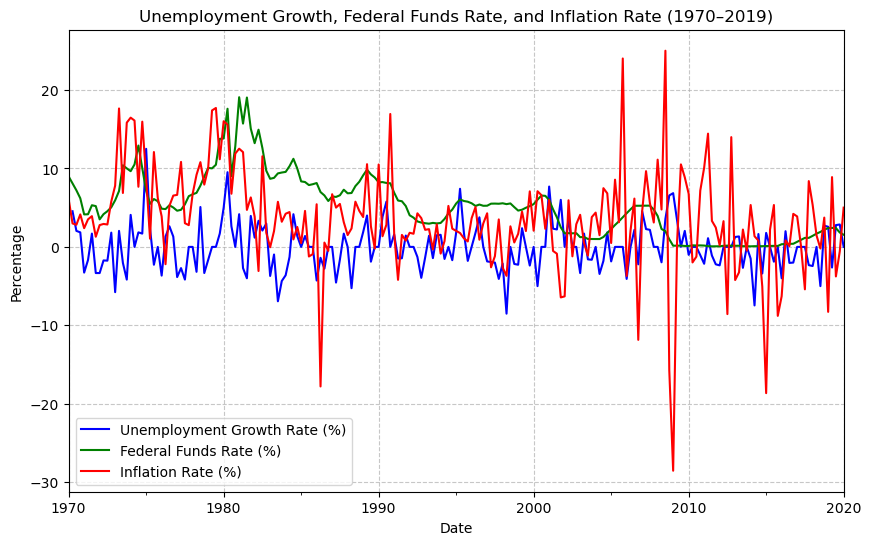

In [232]:
# Import matplotlib.pyplot for customizing the plot
import matplotlib.pyplot as plt

# Create a single figure for all three time series
plt.figure(figsize=(10, 6))  # Set figure size for better readability

# Plot the percentage change in unemployment rate
df['unempgr'].plot(label='Unemployment Growth Rate (%)', color='blue')

# Plot the federal funds rate
df['fedrate'].plot(label='Federal Funds Rate (%)', color='green')

# Plot the inflation rate
df['inflat'].plot(label='Inflation Rate (%)', color='red')

# Add title and labels for clarity
plt.title('Unemployment Growth, Federal Funds Rate, and Inflation Rate (1970–2019)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Percentage')

# Add gridlines for improved readability
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed lines with slight transparency

# Add a legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()

### Observations
***1. Unemployment Growth Rate (Blue Line)***

Volatility: The unemployment growth rate shows high volatility throughout the period, with frequent spikes and dips. It ranges between 0% to 12.5%

#### Recessions: 
A recession is an economic downturn characterized by a significant decline in economic activity across multiple sectors, typically lasting for at least two consecutive quarters (six months). It’s often marked by a drop in gross domestic product (GDP), rising unemployment, reduced consumer spending, and declining business investment.

**Early 1970s:** Sharp spikes in unemployment growth (e.g., around 1974–1975) correspond to the 1973–1975 recession, where unemployment increased rapidly.

**Early 1980s:** Large positive spikes (e.g., 1980–1982) align with the 1980 and 1981–1982 recessions, indicating significant unemployment increases.

**2008–2009:** A notable spike during the Great Recession, reflecting a rapid rise in unemployment.

**Negative Growth:** Negative spikes (e.g., mid-1980s, 2010s) indicate periods where the unemployment rate decreased, often during economic recoveries.

**Trend:** Over time, the amplitude of unemployment growth fluctuations seems to decrease slightly after the 1980s, suggesting more stable labor market dynamics in recent decades.

**2. Federal Funds Rate (Green Line)**

**Range:** The federal funds rate fluctuates between 0% and nearly 20%, with peaks in the late 1970s and early 1980s.

**Key Periods:** 

**Late 1970s to Early 1980s:** The federal funds rate peaks around 20% (e.g., 1980–1981), reflecting the Federal Reserve’s aggressive monetary policy under Paul Volcker to combat high inflation. This period, known as the Volcker disinflation, involved raising interest rates to curb inflation. 

**1980s to 1990s:** The rate gradually declines but remains relatively high (5–10%), with occasional increases to manage inflation.

**2000s:** The rate drops to near 0% during the early 2000s recession and again during the 2008–2009 Great Recession, reflecting the Fed’s efforts to stimulate the economy through low interest rates.

**2010s:** The rate remains near 0% for much of the decade post-2008, with a gradual increase starting around 2015 as the economy recovered.

**Trend:** The federal funds rate shows a long-term decline from the 1980s onward, consistent with a global trend of lower interest rates in advanced economies.

**3. Inflation Rate (Red Line)**

**Volatility:** The inflation rate is highly volatile, ranging from -20% to +15%, with significant swings, especially in the 1970s and 1980s.

**Key Periods:**

**1970s:** High inflation, peaking around 15% (e.g., 1974, 1979–1980), corresponds to the stagflation period, driven by oil price shocks and loose monetary policy.

**Early 1980s:** Inflation drops sharply after peaking, reflecting the success of the Volcker disinflation (high federal funds rates reduced inflation).

**1990s to 2000s:** Inflation stabilizes, generally fluctuating between 0% and 5%, indicating more effective monetary policy and economic stability.

**2008–2009:** A sharp drop to negative values (deflation) during the Great Recession, followed by low inflation (0–5%) in the 2010s, reflecting weak demand and low oil prices.

**Trend:** Inflation has generally trended downward since the 1980s, with fewer extreme spikes, though it remains volatile during economic shocks.

**Relationships Between Variables**

**Federal Funds Rate and Inflation:**
There’s a clear relationship in the 1970s and 1980s: high inflation (red) precedes increases in the federal funds rate (rate hikes) (green), as the Fed raises rates to combat inflation (reduce the circulation of money)

Example: In 1979–1981, inflation peaks above 15%, followed by a federal funds rate peak near 20%. Inflation then falls sharply, demonstrating the effectiveness of tight monetary policy.


**Federal Funds Rate and Unemployment Growth:**

In the early 1980s, the high federal funds rate (green) leads to a spike in unemployment growth (blue), as tight monetary policy slows the economy, increasing unemployment.

During the 2008–2009 recession, the federal funds rate drops to 0%, and unemployment growth spikes, indicating the Fed’s attempt to mitigate unemployment through loose monetary policy.

**Unemployment Growth and Inflation:**

The plot hints at the Phillips Curve relationship (a trade-off between unemployment and inflation):
In the 1970s, high inflation (red) coincides with rising unemployment growth (blue), reflecting stagflation (high inflation and high unemployment).

In the 1980s, as inflation falls, unemployment growth spikes, showing the cost of disinflation.

Post-1990s, the relationship weakens, with both variables showing less extreme movements, suggesting a more stable economic environment.

**Economic Insights**

**1970s Stagflation:** High inflation and rising unemployment growth indicate stagflation, exacerbated by oil shocks and loose monetary policy. The Fed’s response (raising rates) eventually curbed inflation but at the cost of higher unemployment.

**Volcker Disinflation (1980s):** The sharp rise in the federal funds rate successfully reduced inflation but led to recessions and high unemployment growth, illustrating the inflation-unemployment trade-off.

**Great Recession (2008–2009):** Deflation and a spike in unemployment growth occur simultaneously, with the federal funds rate at 0%, showing the limits of monetary policy in deep recessions.

**Post-2009 Recovery:** Low inflation and federal funds rates, with gradually declining unemployment growth, reflect a prolonged recovery period with cautious monetary policy.

In essence, high inflation often precedes federal funds rate increases, as the Fed tightens policy to restore price stability. This, in turn, can elevate unemployment by slowing the economy. Conversely, during downturns like 2008-2009, low rates aim to spur growth, stabilizing employment at the expense of prolonged low inflation.

These insights lay the groundwork for deeper analysis, such as a Vector Autoregression (VAR) model, which could quantify these relationships and forecast how changes in one variable—like the federal funds rate—ripple through unemployment and inflation over time. The EDA’s story is clear: monetary policy is a powerful lever, balancing inflation and employment in a delicate economic dance.

#### 3] Data Preparation continues. We prepare the data to run for vector autoregression. We need to ensure that the data is stationary and we also need to find the number of lags, that is, how many previous variables of a time series variable are necessary to predict the next variable.

#### 3a] Check for stationarity 

#### Why Stationarity Matters and how grouping the data quarterly earlier is related to stationarity
A time series is **stationary** if its statistical properties—like **mean**, **variance**, and **autocorrelation**—stay constant over time. Imagine a steady heartbeat: no wild trends or sudden shifts messing things up. This stability is key for models like Vector autoregression because it makes patterns predictable. If the data isn’t stationary (e.g., it has a trend), the Vector autoregression model can pick up misleading relationships, leading to unreliable results. So, checking stationarity is critical and its like making sure your ingredients are fresh before cooking—they’ve got to be just right!

Recall that we started by calculating the **unemployment growth rate (`unempgr`)** as the percentage change of the unemployment rate (`UNRATE.pct_change() * 100`). Why not use `UNRATE` directly? Raw unemployment rates often trend over time—think economic booms and busts—which makes them have a trend (non-stationary). We also considered quarterly numbers for the federal growth rate and the inflation rate respectively which reduces not only noise in the data but trands as well. 


#### Checking Stationarity with Augmented Dickey-Fuller (ADF) test
To confirm stationarity, I used the **Augmented Dickey-Fuller (ADF) test**. This test checks if a time series is stationary by analyzing its past values (lags) to see if the mean, variance, and autocorrelation are stable over time. It’s like a detective looking for clues that the series isn’t drifting off course.

Here’s the setup:
- **Null Hypothesis**: The series is non-stationary (it has a unit root, meaning it trends or wanders).
- **Alternative Hypothesis**: The series is stationary (no unit root, stable properties).

I sliced the data with **[1:]** to skip the first row because the unemployment growth rate variable, `unempgr` has a **NaN** there. Since `unempgr` is a percentage change, there’s no prior value for the first entry to calculate it—so it’s NaN. Excluding it ensures the ADF test runs on valid numbers. Smart move!

#### ADF Test Output Explained
The ADF test returns a tuple as output:  
**(adf_statistic, p_value, used_lags, n_obs, critical_values, ic_best)**  


- **ADF Statistic**:  
  This is a negative number (e.g., -3.2). You have to compare it to the **critical values**. If it’s *more negative* than the critical value at, say, 5%, you reject the null hypothesis and conclude the series is stationary.

- **p-value**:  
  This tells you the probability of the null hypothesis being true. A small p-value (e.g., < 0.05) means you can reject the null and say, “Yep, it’s stationary!” Aim for something tiny here.

- **Used Lags**:  
  The number of past time steps (lags) the test used, picked automatically based on a criterion like the Akaike Information Criterion (AIC). It’s the test’s way of accounting for autocorrelation.

- **Critical Values**:  
  A dictionary of thresholds at different significance levels, like:  
  `{'1%': -3.45, '5%': -2.87, '10%': -2.57}`  
  If your ADF statistic is more negative than -2.87 (at 5%), you’ve got stationarity.

- **ic_best**:  
  The value of the information criterion (e.g., AIC) used to choose the lags. It’s a behind-the-scenes detail to optimize the test.

#### Interpreting the Results
For your series to be stationary:
- The **ADF statistic** should be more negative than the **5% critical value** (e.g., < -2.87).
- The **p-value** should be small (< 0.05), showing strong evidence against non-stationarity.

If `unempgr` passes this test (e.g., ADF statistic = -3.5, p-value = 0.01), it’s stationary—perfect for VAR. If not, we need further transformations, like differencing (detrending a time series variable).

In [100]:
sts.adfuller(df.unempgr[1:])

# Unemployment Growth Rate (unempgr): Stationary (p-value ≈ 0.000000431, ADF statistic -5.81 < 5% critical value -2.88). 
# the unemployment growth rate is stationary 

(-5.814932891137989,
 4.314525650913798e-07,
 11,
 188,
 {'1%': -3.465620397124192,
  '5%': -2.8770397560752436,
  '10%': -2.5750324547306476},
 905.303520770794)

In [101]:
sts.adfuller(df.fedrate[1:])

# The adf_statistic < 5% p-value, [100-38=62% level of confidence]. But we need to approve this result with a 95% l.o.c
# The ADF statistic -1.79 > 5% critical value -2.88). 
# Thus, the fed lending rate is non-stationary. To correct this, we do "first differencing" and re-test for stationarity. 


(-1.7866603892176622,
 0.3871042617320926,
 9,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 575.49751244204)

In [102]:
sts.adfuller(df.inflat[1:])

# Inflation Rate (inflat): Stationary at 5% level (p-value = 0.0107, ADF statistic -3.41 < 5% critical value -2.88), 
# but plot suggests non-stationarity. we could do differencing for robustness but we won't since statistically, 
# the inflation rate variable is significant

(-3.406368584345607,
 0.010743673463549111,
 5,
 194,
 {'1%': -3.4645146202692527,
  '5%': -2.8765564361715534,
  '10%': -2.5747745328940375},
 1206.6657488186788)

#### Observations from the Augmented Dickey-Fuller test

#### i) Unemployment Growth Rate (unempgr):
**Stationary**: The ADF test strongly confirms stationarity (p-value ≈ 0.000000431, ADF statistic well below the 5% critical value). Thus, we can use `unempgr` directly in the VAR model without transformation.
This makes sense because unempgr is already a differenced series (percentage change of UNRATE), which typically removes trends.

#### ii) Federal Funds Rate (fedrate):
**Non-Stationary**: The ADF test indicates non-stationarity (p-value = 0.387, ADF statistic above the 5% critical value). We need to transform this series, likely by first differencing (df['fedrate'].diff()), then re-run the ADF test on the differenced series to confirm stationarity.
This aligns with the plot, where fedrate shows a clear trend (peaking in the 1980s, then declining), a common sign of non-stationarity in economic data.

#### iii) Inflation Rate (inflat): 
**Stationary at 5% Level:** The ADF test suggests stationarity at the 5% level (p-value = 0.0107, ADF statistic below the 5% critical value), but the evidence is weaker than for unempgr (p-value close to 0.01, ADF statistic near the 1% critical value).

The plot shows trends and volatility (e.g., high in the 1970s, dropping later), which often indicates non-stationarity. In practice, for a VAR model, we might still apply first differencing to ensure robust stationarity, especially since economic inflation data often has unit roots. 

##### How to correct for non-constant mean, variance and autocorrelation for a time series variable like sales? Remeber that variables like sales have a pattern over time or cyclical patterns or seasonal patterns. Thus, previous values (n-1) cannot be used to predict the value for now (n). Thus, non-stationarity (the mean, variance and autocorrelation are not constant for a particular number of lags). Thus, to make such a variable stationary, we need to remove the trend, cyclic or seasonal behavior of the series. Do Yn-Yn-1 and get a new series Y'=Yn-Yn-1 and test for stationarity

#### 3b] Correct the `federal funds rate` variable for non-stationarity and visualize the trend again

To correct for non-constant mean, variance and autocorrelation for a time series variable like sales, (variables like sales have a pattern over time - cyclical patterns or seasonal patterns) means removing the pattern from the variable. In practice, this means previous values (n-1) of sales cannot be used to predict future sales values (n). Thus, non-stationarity (the mean, variance and autocorrelation are not constant for a particular number of lags). To make such a variable stationary we do `Yn-Yn-1` and get a new series `Y'=Yn-Yn-1` and test for stationarity again. If not stationary, we do second degree differencing.

In [233]:
# Apply first degree differencing to the fed lending rate variable 
df['dfedrate']=df.fedrate.diff().dropna()
df.head()

,UNRATE,unempgr,fedrate,inflat,dfedrate
DATE,,,,,
1970-01-31,3.9,NaN,8.98,6.077632,NaN
1970-04-30,4.6,4.545455,8.10,2.988400,-0.88
1970-07-31,5.0,2.040816,7.21,2.820601,-0.89
1970-10-31,5.5,1.851852,6.20,4.140483,-1.01
1971-01-31,5.9,-3.278689,4.14,2.385616,-2.06


#### Visually inspect for Stationarity again
Both visually and statistically, the differenced federal funds variable is now stationary. We're all set to run the inital Vector autoregression model on the entire dataset amd explain how monetary policy (federal funds lending rate) has impacted unemployment growth rate and the inflation rate from 1970 to 2019.

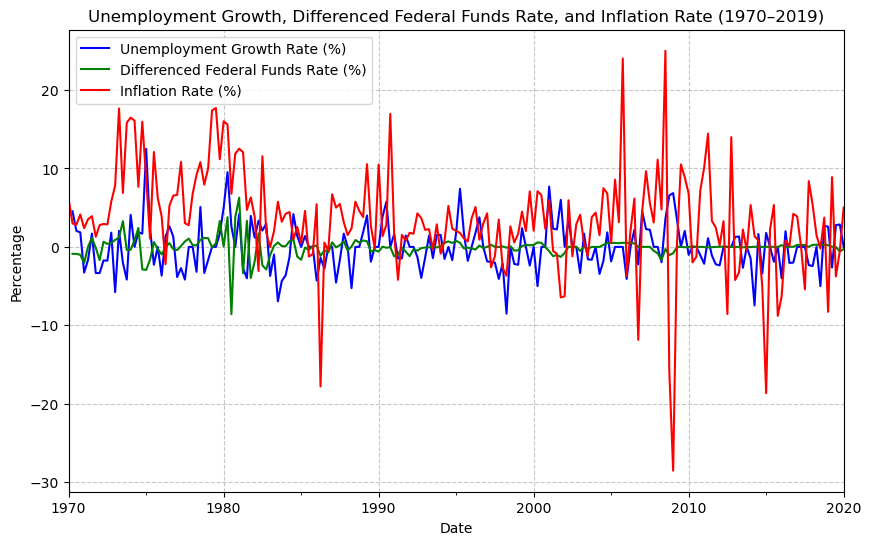

In [234]:
# Create a single figure for all three time series
plt.figure(figsize=(10, 6))  # Set figure size for better readability

# Plot the percentage change in unemployment rate
df['unempgr'].plot(label='Unemployment Growth Rate (%)', color='blue')

# Plot the federal funds rate
df['dfedrate'].plot(label='Differenced Federal Funds Rate (%)', color='green')

# Plot the inflation rate
df['inflat'].plot(label='Inflation Rate (%)', color='red')

# Add title and labels for clarity
plt.title('Unemployment Growth, Differenced Federal Funds Rate, and Inflation Rate (1970–2019)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Percentage')

# Add gridlines for improved readability
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed lines with slight transparency

# Add a legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()

#### Observation: 
Visually, the differenced series appears constant. We can verify that statistically using the ADF test. The ADF statistic, -5.87 < -2.87 (the p-value at 5%) implies that we reject the alternate hypothesis that there is a difference in mean, median and autocerrelation for the last 7 lags of the differenced federal funds rate has a constant mean, variance and aucorrelation coefficient. Thus, we conclude with a 95% level of confidece that the differenced federal funds rate variable is stationary.

In [235]:
sts.adfuller(df.dfedrate[1:])

(-5.8797052573219935,
 3.099113945858345e-07,
 7,
 192,
 {'1%': -3.4648754262570978,
  '5%': -2.876714157488788,
  '10%': -2.574858699001736},
 576.5374523322605)

#### 4] Fitting an initial Vector autocorrelation (VAR) model
We fit an initial vector autocorrelation model. We begin by creating a cleaned dataframe with the variables `unempgr`, `dfedrate`, `inflat` for the unemploymet growth rate, differenced growth rate and inflation rate respectively and slize the dataset from the first variable onward, avoiding the 'NaN' variable at index 0.

The VAR model treats all variables as endogenous, meaning each variable is a function of its own past values and the past values of the other variables (lags). The output provides insights into these relationships, which can help understand how monetary policy (via the federal funds rate) affects unemployment and inflation. Pretty much, an ordinary least squared regression is run and the lagged values serve as variables in the Ordinary Least Square (OLS) regression equation. I randomly chose three (3) lags for this intial model, which yields 9 equations (3 variables with 3 lags each). We will do anlysis to determine the the order of the VAR model otherwise known as the lags to use for the model.

Looking at the output of VAR, for each of the variables in the dataset, there's a regression output showing the relatuionship between the variables - differenced federal funds rate, unemployment growth rate and inflation rate variables - and the lagged 9 components. 

The prob column of the result is the p-value for the t-test. If p-value < 0.05, the coefficient is statistically significant at a 5% confidence interval (reject the null hypothesis that the coefficient is zero).

#### 4a] Methodology for selecting the Optimal Number of Lags for the VAR Model

The optimal number of lags for the `Vector Autoregression (VAR) model` was determined through a rigorous process. Initially, a model with 3 lags was fitted as a baseline. The `Akaike Information Criterion (AIC)` was used to `identify the lag order with the lowest value`, balancing model fit and complexity. The `log likelihood` was evaluated, with `higher values indicating better data fit`. Additionally, the `correlation matrix of residuals` was analyzed to ensure low correlations, minimizing unexplained patterns. The `Partial Auto-Correlation Function (PACF)` was also used to determine the lag order. While `Partial Auto-Correlation Function (PACF)` suggested 4–5 lags, iterative testing of lags 3 to 7 showed 3 lags achieved the lowest AIC, highest log likelihood, and lowest residual correlations, ensuring an optimal fit for analyzing monetary policy impacts on inflation and unemployment. 

`Here is a deeper analysis of the methodology:`

**4ai] Model Selection by Comparing Information Criteria**

Information criteria measure the information lost by the model, with lower values indicating the best model fit. I evaluated the following information criteria (ic):

**Akaike Information Criterion (AIC):** Balances fit and complexity.

**Bayesian Information Criterion (BIC):** Penalizes complexity more heavily.

**Hannan-Quinn Information Criterion (HQIC):** Balances fit and parsimony.

**Log Likelihood:** Measures how well the model explains the data; `higher values indicate better fit`. It’s critical as it quantifies the probability of observing the data given the model, guiding optimal lag selection.

Using AIC as the primary metric, I tested up to 3 lags (maxlags=3) and selected the lag order with the lowest AIC. Then, I evaluated residuals using the correlation matrix for residuals.

**4aii] Evaluating Residuals**
I analyzed the correlation matrix of residuals to assess unexplained dependencies. `Lower correlations suggest the model captures key relationships`. Additionally, serial correlation of residuals was checked to detect leftover patterns in errors. If residuals show correlation, it indicates unmodeled patterns in the time series, requiring actions like increasing the lag order or adding predictors.

**4aiii] Iterative Lag Selection**
The AIC criteria suggested 5 lags, but I tested lags from 3 to 7 (-2 < maxlags < +2). I selected 3 lags due to:

`Higher log likelihood`, indicating better fit.
`Lower residual correlations`, minimizing unexplained dependencies.

**4aiv] Partial Auto-Correlation Function (PACF) Analysis**
A brief about Auto-Correlation function. It is used to measure how strong a previous period's value (yesterday's stock price for example, last quarter/month/week's stock price) is correlated to the current period's stock price. This will help show how yesterday's stock price predicts today's stock price. 

For **partial autocorrelation function (PACF)**, it measures the influence of 3 previous stock values  denoted `T-3` and today's value, `T`. But period `T-3`'s value might be correlated to period `T-4` value and so on. Thus, because of the influence of previous period's influence on the `T-3` value, we have to remove that influence to measure the correlation or real correlation of any two time spots while down-playing that of other periods. This is what PACF does. 

**PACF plots identify statistically significant lags (vertical lines exceeding the shaded area).** For this model:

**Unemployment growth rate and inflation rate:** 4 previous quarters were significant.
**Differenced federal funds rate:** 5 previous quarters were significant.

Despite PACF suggesting 4–5 lags, I proceeded with 3 lags.

#### Final Model
`The VAR model with 3 lags was chosen` for its `lowest AIC`, `highest log likelihood`, and `low residual correlations`, ensuring optimal fit for analyzing monetary policy impacts on inflation and unemployment.

#### Create a new dataframe with the variables 'unempgr', 'dfedrate', and 'inflat'

In [238]:
from statsmodels.tsa.api import VAR
# create a clean DataFrame for the VAR: that is containing the differenced federal leding rate variable
vardf=df[['unempgr', 'dfedrate', 'inflat']][1:]
vardf.head()

,unempgr,dfedrate,inflat
DATE,,,
1970-04-30,4.545455,-0.88,2.988400
1970-07-31,2.040816,-0.89,2.820601
1970-10-31,1.851852,-1.01,4.140483
1971-01-31,-3.278689,-2.06,2.385616
1971-04-30,-1.666667,0.02,3.513699


#### Run Vector Autoregression with 3 lags for a start and evaluate the results 

In [108]:
model=VAR(vardf)
results=model.fit(maxlags=3)  #ic='aic' uses information criterion to use for VAR order selection
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     14:10:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.72061
Nobs:                     197.000    HQIC:                   6.42303
Log likelihood:          -1421.33    FPE:                    503.154
AIC:                      6.22063    Det(Omega_mle):         433.699
--------------------------------------------------------------------
Results for equation unempgr
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.375598         0.270395           -1.389           0.165
L1.unempgr          0.166240         0.071725            2.318           0.020
L1.dfedrate        -0.011916         0.176507           -0.068    

#### Analysis of VAR results

#### i) Analysis for unemployment growth rate equation
All lagged values for unemplyment growth rate, inflation and unemplyment have p-values > 0.05, so they are not statistically significant. Which means that unemployment growth rate one, two and three quarters ago do not affect the unemplyment growth rate in the current period. Similarly, the inflation in the past three quarters do not affect the inflation in the current period/quarter. Similarly, the differenced federal funding rate in the last three quarters do not affect the unemployment growth rate which does not reflect the real economy. 

#### ii) Differenced federal funds rate equation analysis
**Significant Coefficients (p-value < 0.05):**
**L1.unempgr:** Coefficient = -0.100839, p-value = 0.001

On average and holding everything else equal, a 1% increase in unemployment growth one period ago decreases the change in the federal funds rate by 0.100839% in the current period. This is significant, **suggesting that rising unemployment growth leads the Feds to lower interest rates (a decrease in dfedrate), likely to stimulate the economy.**

**L1.dfedrate:** Coefficient = -0.189210, p-value = 0.010
The federal funds rate’s own lag has a negative effect: On average and holding everything else equal, a 1% increase in dfedrate one period ago reduces dfedrate by 0.189210% in the current period. **This suggests some mean-reversion or policy adjustment in the federal funds rate.**

**Insignificant Coefficients:**
The constant, lagged inflation (L1.inflat, L2.inflat, L3.inflat), and other lags of unempgr and dfedrate have p-values > 0.05, so they are not statistically significant. For example:
**L1.inflat (p-value = 0.190): Inflation one period ago does not significantly affect the change in the federal funds rate.**
This suggests that, in this model, the Fed’s response (via dfedrate) is more strongly influenced by recent unemployment growth than by inflation.

**Interpretation:**
The Fed appears to respond to unemployment growth: when unemployment growth rises, the federal funds rate tends to decrease (negative coefficient), reflecting a policy to ease monetary conditions during economic downturns.

**The lack of significant effects from inflation lags is surprising, as the Fed typically raises rates to combat inflation (e.g., Volcker disinflation in the 1980s). This might indicate that the model’s lag structure (3 lags) doesn’t fully capture inflation’s effect, or that differencing fedrate altered the dynamics.**


#### iii) Analysis for Equation of inflation

Significant Coefficients (p-value < 0.05):
const: Coefficient = 2.390732, p-value = 0.000
The constant term is significant, indicating a baseline inflation rate of about 2.39% when all lagged variables are zero.

**L1.dfedrate: Coefficient = 1.021264, p-value = 0.008**
On average and holding everything else equal, a 1% increase in the "change in the federal funds rate" one period ago leads to an increase in inflation by 1.021264% in the current period. **This is significant but counterintuitive—typically, a higher federal funds rate reduces inflation (e.g., Volcker disinflation). This positive coefficient might reflect the differenced nature of dfedrate or complex lagged dynamics.**

**L1.inflat: Coefficient = 0.165790, p-value = 0.022**
Inflation has persistence: a 1% increase in inflation one period ago increases current inflation by 0.165790%. This is expected, as inflation often exhibits autocorrelation.

**L2.dfedrate: Coefficient = 0.859919, p-value = 0.029**
On average and holding everything else equal, a 1% increase in the change in the federal funds rate two periods ago increases inflation by 0.859919%. Again, this is unexpected, as higher interest rates typically reduce inflation.

**L3.inflat: Coefficient = 0.158996, p-value = 0.024**
Inflation three periods ago has a positive effect: a 1% increase in inflation three periods ago increases current inflation by 0.158996%, showing longer-term persistence.

**Insignificant Coefficients:**
Lagged unemployment growth (L1.unempgr, L2.unempgr, L3.unempgr) and some lags of dfedrate and inflat have p-values > 0.05, so they are not significant.

L1.unempgr (p-value = 0.174): Unemployment growth one period ago does not significantly affect inflation.

**Interpretation:**
Inflation is persistent (L1.inflat, L3.inflat are significant), meaning past inflation strongly influences current inflation.
The positive coefficients for L1.dfedrate and L2.dfedrate are surprising. In economic theory, an increase in the federal funds rate (or its change) should reduce inflation by tightening monetary conditions. This result might be due to:
The use of dfedrate (differenced federal funds rate), which complicates interpretation. A positive dfedrate means the federal funds rate is increasing, but the lagged effect might reflect inflation expectations or reverse causality.

The model’s lag structure (3 lags) might not capture longer-term dynamics where the federal funds rate reduces inflation.
Unemployment growth does not significantly affect inflation, suggesting a weak Phillips Curve relationship in this model (no trade-off between unemployment and inflation).

#### Model Selection by Comparing Information Criteria

Information criteria measure the amount of information lost by the model. So, the lowest information cirterion represents the best model. 

The order of the VAR using the information criteria: Lag 5 is the best order for the VAR model using the AIC and FPE criteria - consistent with the function methodologgy - while Lag 1 is the best order for the VAR model using the HQIC criteria and at Lag 0 using BIC. We will go with 5 lags using the AIC. Now, lets re-run VAR with 5 lags

In [109]:
model_comparison = model.select_order(maxlags=8)  #ic='aic' uses information criterion to use for VAR order selection
model_comparison.summary()

,AIC,BIC,FPE,HQIC
0,6.397,6.448*,600.0,6.418
1,6.253,6.457,519.7,6.336*
2,6.261,6.617,523.9,6.405
3,6.246,6.755,516.2,6.452
4,6.233,6.895,509.8,6.501
5,6.144*,6.958,466.3*,6.473
6,6.189,7.156,488.1,6.580
7,6.184,7.304,486.3,6.637
8,6.186,7.458,487.8,6.701


#### We then defined a function to find the optimal lag length using the information criteria and 5 lags was recommended by the function, confirming the above results.

In [239]:
def select_var_lags(vardf, maxlags=8, ic='aic'):
    """
    Select the optimal lag length for a VAR model based on an information criterion.

    Parameters:
    - data: pandas DataFrame with time series variables
    - maxlags: int, maximum number of lags to test (default=8)
    - ic: str, information criterion to use ('aic', 'bic', 'hqic') (default='aic')

    Returns:
    - optimal_lag: int, the lag length with the lowest information criterion
    """
    # Dictionary to store information criteria values for each lag length
    ic_values = {}

    # Fit VAR models for each lag length from 1 to maxlags
    for lag in range(1, maxlags + 1):
        try:
            # Fit the VAR model with the current lag length
            model = VAR(vardf).fit(lag)
            # Store the information criterion value
            if ic == 'aic':
                ic_values[lag] = model.aic
            elif ic == 'bic':
                ic_values[lag] = model.bic
            elif ic == 'hqic':
                ic_values[lag] = model.hqic
            else:
                raise ValueError("Invalid information criterion. Use 'aic', 'bic', or 'hqic'.")
        except Exception as e:
            print(f"Error fitting VAR with {lag} lags: {e}")
            continue

    # Check if any models were successfully fitted
    if not ic_values:
        raise ValueError("No valid VAR models were fitted.")

    # Find the lag length with the minimum information criterion value
    optimal_lag = min(ic_values, key=ic_values.get)
    print(f"Optimal lag length based on {ic.upper()}: {optimal_lag}")
    return optimal_lag

# Run the function to find the optimal lag length
optimal_lag = select_var_lags(vardf, maxlags=8, ic='aic')
print(f"The best maxlags number is: {optimal_lag}")

Optimal lag length based on AIC: 5
The best maxlags number is: 5


#### Re-run VAR with the optimal information criteria, 5-lags

In [110]:
model=VAR(vardf)
results=model.fit(maxlags=5)  #ic='aic' uses information criterion to use for VAR order selection
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     14:10:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.92826
Nobs:                     195.000    HQIC:                   6.44880
Log likelihood:          -1379.03    FPE:                    456.553
AIC:                      6.12260    Det(Omega_mle):         360.370
--------------------------------------------------------------------
Results for equation unempgr
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.474650         0.301005           -1.577           0.115
L1.unempgr          0.121327         0.074447            1.630           0.103
L1.dfedrate        -0.081590         0.178238           -0.458    

#### Analysis of Correlation matrix of residuals for both models 

Analysis of Residual Correlation Matrices for Lag Selection suggests 3-lags is the optimal number of lags

##### i) First Matrix (3 Lags):

unempgr-dfedrate: -0.042438
unempgr-inflat: -0.031272
dfedrate-inflat: 0.166444

**Max correlation is 0.166444.**

##### ii) Second Matrix (5 Lags):

unempgr-dfedrate: -0.069214
unempgr-inflat: -0.060634
dfedrate-inflat: 0.191428

**Higher correlations (max 0.191428)**

The correlations are generally low, but model with 3 lags has relatively lower correlations than that with 5 lags, indicating the model with 3 lags captures most dependencies. However, the higher correlation of 0.166444 and 0.191428 between dfedrate and inflat for 3 and 5 lags respectively, hint at potential unmodeled dynamics. 

#### Look at the residuals of the model per variable to see if they capture some behavior over time. If they do, it means the model didn't capture this and this is not great. 

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). What does this mean to us? If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system, among other.

`The visual shows the following:`

i) The Differenced federal funds rate and unemployment growth rate residual plot appear to show a uniform behavior over time. 

ii) There are structural breaks (e.g., 1970s oil crises, 1980s Volcker disinflation, 2008 financial crisis). The residual plot might show large residuals (spikes) during these periods, indicating the model struggled to capture these exogenous shocks. 

iii) Variance Over Time: If the residuals for inflat show increasing or decreasing variance (e.g., wider spreads in the 1970s due to high inflation volatility), this could indicate heteroskedasticity, suggesting the model assumptions are violated. Because of stationarity holding for all these variables, we see no concern of heteroskedasticity here. 

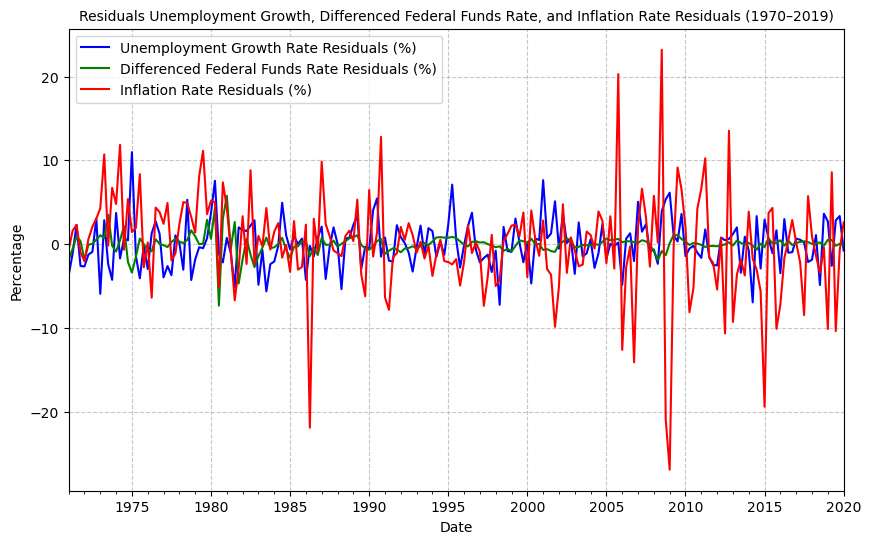

In [240]:
model=VAR(vardf)
results=model.fit(maxlags=3)


plt.figure(figsize=(10, 6))  # Set figure size for better readability

# Plot the percentage change in unemployment rate
results.resid.unempgr.plot(label='Unemployment Growth Rate Residuals (%)', color='blue')

# Plot the federal funds rate
results.resid.dfedrate.plot(label='Differenced Federal Funds Rate Residuals (%)', color='green')

# Plot the inflation rate
results.resid.inflat.plot(label='Inflation Rate Residuals (%)', color='red')

# Add title and labels for clarity
plt.title('Residuals Unemployment Growth, Differenced Federal Funds Rate, and Inflation Rate Residuals (1970–2019)', fontsize=10)
plt.xlabel('Date')
plt.ylabel('Percentage')

# Add gridlines for improved readability
plt.grid(True, linestyle='--', alpha=0.7)  # Use dashed lines with slight transparency

# Add a legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()

#### Combining the evaluation criteria for `Log Likelihood`, and `Correlation of Residuals` for VAR models with 3 - 8 lags. 3-lags is chosen. 

In [111]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR

def compare_var_lags(vardf, lags_list=[3, 4, 5, 6, 8]):
    """
    Run VAR models with different maxlags values and print key metrics to the console.

    Parameters:
    - vardf: pandas DataFrame with time series variables (e.g., unempgr, dfedrate, inflat)
    - lags_list: list of integers, the maxlags values to test (default=[3, 4, 5, 6, 8])

    Returns:
    - None (prints results directly to the console)
    """
    # Initialize a dictionary to store results
    results = {}

    for lags in lags_list:
        try:
            # Fit the VAR model with the current maxlags
            model = VAR(vardf).fit(maxlags=lags)

            # Extract key metrics
            log_likelihood = model.llf  # Log likelihood
            residual_corr = model.resid.corr()  # Correlation matrix of residuals

            # Flatten the upper triangle of the correlation matrix (excluding diagonal)
            corr_values = residual_corr.where(np.triu(np.ones(residual_corr.shape), k=1).astype(bool)).stack()

            # Store metrics
            results[lags] = {
                'log_likelihood': log_likelihood,
                'residual_correlations': corr_values.to_dict()
            }

        except Exception as e:
            print(f"Error fitting VAR with maxlags={lags}: {e}")
            continue

    # Print results directly to the console
    print("VAR Model Comparison Across Different maxlags Values")
    print("=" * 50 + "\n")
    for lags, metrics in results.items():
        print(f"maxlags = {lags}")
        print(f"Log Likelihood: {metrics['log_likelihood']}")
        print("Correlation of Residuals (Upper Triangle):")
        for (var1, var2), corr in metrics['residual_correlations'].items():
            print(f"  {var1} - {var2}: {corr:.6f}")
        print()

# Example usage:
compare_var_lags(vardf, lags_list=[3, 4, 5, 6, 8])


VAR Model Comparison Across Different maxlags Values

maxlags = 3
Log Likelihood: -1421.325077868894
Correlation of Residuals (Upper Triangle):
  unempgr - dfedrate: -0.042438
  unempgr - inflat: -0.031272
  dfedrate - inflat: 0.166444

maxlags = 4
Log Likelihood: -1403.0686474987722
Correlation of Residuals (Upper Triangle):
  unempgr - dfedrate: -0.044187
  unempgr - inflat: -0.054665
  dfedrate - inflat: 0.184235

maxlags = 5
Log Likelihood: -1379.032207294883
Correlation of Residuals (Upper Triangle):
  unempgr - dfedrate: -0.069214
  unempgr - inflat: -0.060634
  dfedrate - inflat: 0.191428

maxlags = 6
Log Likelihood: -1367.5245026005332
Correlation of Residuals (Upper Triangle):
  unempgr - dfedrate: -0.071901
  unempgr - inflat: -0.067140
  dfedrate - inflat: 0.192179

maxlags = 8
Log Likelihood: -1336.12007320176
Correlation of Residuals (Upper Triangle):
  unempgr - dfedrate: -0.086816
  unempgr - inflat: -0.063494
  dfedrate - inflat: 0.162611



#### Partial Auto-Correlation Function Analysis for lag selection

PACF plots identify statistically significant lags (vertical lines exceeding the shaded area). For this model:

**Unemployment growth rate and inflation rate:** 4 previous quarters were significant.

**Differenced federal funds rate:** 5 previous quarters were significant.

**Conclusion:**
We choose 3-lags for its `lowest AIC`, `highest log likelihood`, and `low residual correlations`, ensuring optimal fit for analyzing monetary policy impacts on inflation and unemployment.

Text(0.5, 1.0, 'PACF for unempgr residuals')

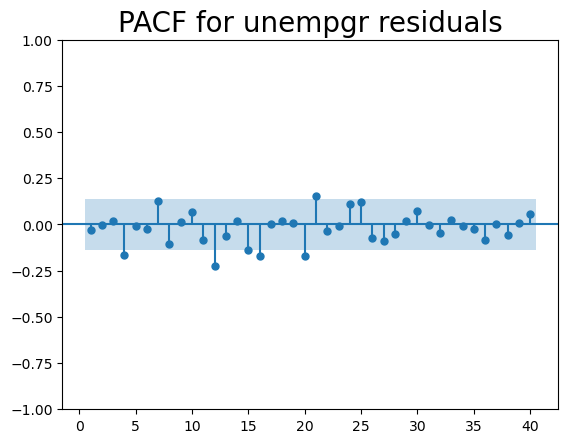

In [113]:
sgt.plot_pacf(results.resid.unempgr, lags=40, zero=False, method='ols')
plt.title("PACF for unempgr residuals", size=20)

Text(0.5, 1.0, 'PACF for federal fund rate residuals')

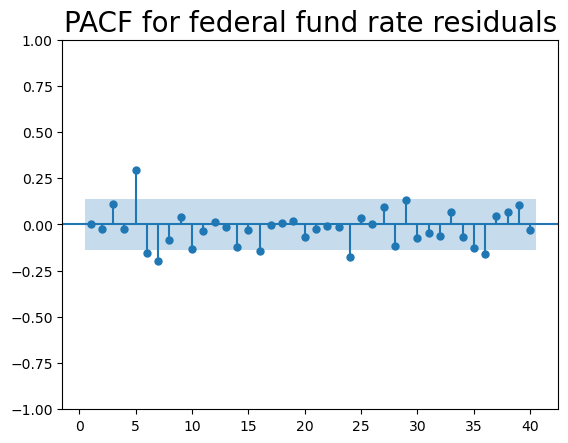

In [29]:
sgt.plot_pacf(results.resid.dfedrate, lags=40, zero=False, method='ols')
plt.title("PACF for differenced federal fund rate residuals", size=20)

Text(0.5, 1.0, 'PACF for inflation residuals')

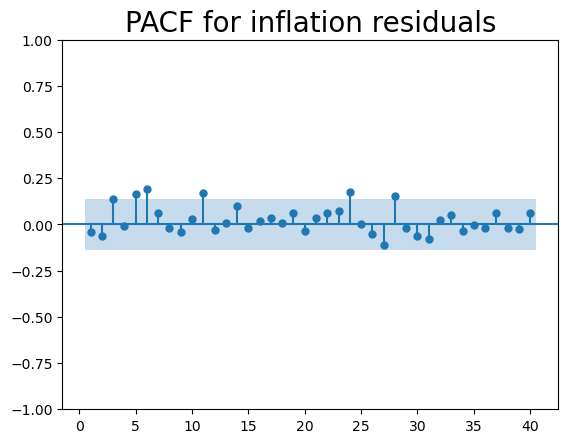

In [30]:
sgt.plot_pacf(results.resid.inflat, lags=40, zero=False, method='ols')
plt.title("PACF for inflation residuals", size=20)

### 5] Prediction

**Good to know:** 
To express the forecasts in terms of the original fedrate (the differenced federal fund rate variable was used for the model since the original variable wasn't stationary), we will reverse the differencing process. Starting with the last observed value of fedrate from the training data, we cumulatively add the forecasted dfedrate values. For example: Suppose the last known fedrate is 2.0%, and the VAR model forecasts dfedrate as 0.3% for the next period. The forecasted fedrate becomes 2.0% + 0.3% = 2.3%. For the next period, if dfedrate is forecasted as 0.2%, you add it to 2.3%, getting 2.5%, and so on.

#### 5a] Splitting the data ito train and test datasets
We split the data into 96% and 4% for the training and test dataset. 

The choice of 8 quarters (2 years) or 4% of the data for the test set reflects a practical balance tailored to the project’s goal — analyzing monetary policy impacts and the idea is to have a large train set. Our entire data contains 197 observations, reserving 8 quarters (2 years) for testing leaves 189 observations for training for a VAR model and ensures the evaluation reflects the model’s ability to handle contemporary monetary policy dynamics.

We used a Vector Autoregression (VAR) model to forecast three key economic indicators—unemployment growth rate (unempgr), differenced federal funds rate (dfedrate), and inflation rate (inflat)—over the next 8 quarters (2 years), starting from May 2025. This helps predict economic trends for business decisions, like hiring or pricing, during potential economic shifts such as a recession.

I evaluated model accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), as percentage metrics were unreliable due to near-zero actual values.

The `MAE (Mean Absolute Error)` measures the average prediction error in percentage. A lower MAE indicates more accurate predictions, showing typical error size. The `RMSE (Root Mean Squared Error)` on the other hand measures the square root of average squared errors, also in the same units (percentage). It penalizes larger errors more, highlighting significant deviations. `A lower RMSE indicates better overall fit`, especially if large errors matter.

#### How well does our model perform?
`Unemployment Growth rate (unempgr)`: MAE 2.51, RMSE 2.81, indicate moderate errors (average 2.51% off) with slight underprediction (0.69% average). Predictions are fairly reliable but miss some dynamics.

`Federal Funds Rate (dfedrate)`: MAE 0.18, RMSE 0.24. Highly accurate (average 0.18% off) with minimal bias (-0.02%). Forecasts are trustworthy for monetary policy impacts.

`Inflation (inflat)`: MAE 4.44, RMSE 5.65. Significant overprediction (-2.73% average) and large errors (average 4.44% off, with bigger errors inflating RMSE). Predictions are unreliable, needing improvement. That is, either increase the lag number or add predictors like GDP.

In conclusion, the model excels at predicting federal funds rate changes (low errors), is decent for unemployment growth, but struggles with inflation (high errors). For business leaders, this means confidence in interest rate forecasts for financial planning, cautious use of unemployment predictions for hiring, and a need for better inflation forecasts for pricing. We recommend enhancing the model with additional economic indicators to improve accuracy, especially for inflation, critical during economic shifts.

In [271]:
# ':-8' selects all rows except the last 8 quarters (approximately 2 years) for training
train = vardf[:-8]

# '-8:' selects the last 8 quarters as the test set to evaluate the model's forecasting performance
test = vardf[-8:]

# train.head()
test.head()

,unempgr,dfedrate,inflat
DATE,,,
2018-04-30,0.000000,0.28,1.463685
2018-07-31,-5.000000,0.22,-0.203567
2018-10-31,2.702703,0.28,3.735127
2019-01-31,2.564103,0.21,-8.281378
2019-04-30,-2.631579,0.02,8.897279


#### Fit the Vector autoregression model on the train data with 3-lags

In [272]:
import random 
random.seed(1)

# Initialize a VAR model using the training data
# 'VAR' from statsmodels.tsa.vector_ar.var_model is used to create a Vector Autoregression model
# The model will capture the lagged relationships among 'unempgr', 'dfedrate', and 'inflat'
model = VAR(train)

# Define the maximum number of lags to include in the VAR model
# 'lags=3' means the model will consider up to 3 lagged quarters for each variable
# This choice affects how far back the model looks to predict current values
lags = 3

# Fit the VAR model with the specified number of lags
# 'model.fit(maxlags=lags)' estimates the model parameters using the training data
# The result, 'results', contains the fitted model, including coefficients, residuals, and diagnostics

results = model.fit(maxlags=lags)

#### Forecast Initialization: 
When forecasting beyond the training data, the model starts with the most recent known values—the last lags rows of the training set. For lags=3, this means the last 3 quarters of train (e.g., Q2 2017, Q3 2017, Q4 2017 since the training data ends in 2017).

Without `fcinput`, the model wouldn’t know where to start forecasting, as it relies on historical data to initialize the prediction process. But because we are not USING THE ENTIRE TRAIN data, we extract the last three quarter data from the train because that's whats relevant to this analysis.

In [273]:
# We found from previous analysis that we need three most recent quarters to predict the value for the current quarter
# Thus, our starting point is thus from there, and to extract that we do -3 and it is defined below as "-1*lags=3 = -3" 
# and its extracted as an array 
# [-1*lags:]: Slices the array to select the last lags rows (e.g., last 3 quarters if lags=3) 
# fc = forecast 
# fcinput: A NumPy array containing the most recent lags rows of data, used as the starting point for forecasting

fcinput=train.values[-1*lags:] #extract the last tree quarters from the train data (3 lags)
fcinput

array([[ 0.        ,  0.25      , -5.41043   ],
       [-2.3255814 ,  0.        ,  8.386921  ],
       [-2.43902439,  0.26      ,  5.352624  ]])

#### How does the forecast work in practice?
The results.forecast(y=fcinput, steps=8) method in statsmodels generates forecasts iteratively:

**Step 1:** Use fcinput (last 3 quarters of training data) to predict the first quarter (Q1 2018)

**Step 2:** Use the last 2 quarters of fcinput plus the predicted Q1 2017 values to predict Q2 2018

**Step 3:** Use the last quarter of fcinput plus the predicted Q1 2018 and Q2 2018 values to predict Q3 2018

This process continues for 8 steps (quarters).

In [274]:
# We generate forecasts for the next 8 quarters using the fitted VAR model
# remember, "results" is the initial results for the VAR model fitted with the entire train data

fc=results.forecast(y=fcinput, steps=8)
fc

array([[-1.23839835,  0.15006551,  2.97676188],
       [-0.26390009,  0.18916182,  3.67503652],
       [-0.12325349,  0.08008103,  3.35045811],
       [-0.17854679, -0.01826272,  3.41317018],
       [-0.08469622, -0.00464532,  3.73860043],
       [-0.10489712, -0.01701043,  3.65241736],
       [-0.12078568, -0.02326558,  3.62225664],
       [-0.09705465, -0.01758697,  3.68768116]])

In [275]:
# The above array's columns are named exactly as the test data columns are
# Convert the forecast array into a pandas DataFrame for easier handling and visualization
# 'pd.DataFrame(fc, index=test.index, columns=test.columns)' aligns the forecast with the test set's index and columns
# This ensures the forecast matches the test data's time periods and variable names

df_fc=pd.DataFrame(fc, index=test.index, columns=test.columns)
df_fc

,unempgr,dfedrate,inflat
DATE,,,
2018-04-30,-1.238398,0.150066,2.976762
2018-07-31,-0.263900,0.189162,3.675037
2018-10-31,-0.123253,0.080081,3.350458
2019-01-31,-0.178547,-0.018263,3.413170
2019-04-30,-0.084696,-0.004645,3.738600
2019-07-31,-0.104897,-0.017010,3.652417
2019-10-31,-0.120786,-0.023266,3.622257
2020-01-31,-0.097055,-0.017587,3.687681


#### Visualize the results of the forecast
We see overall that the `dfedrate` forecast is highly reliable for financial planning, while `unempgr` is moderately useful for hiring decisions but misses volatility. The `inflat` forecast is unreliable for pricing strategies due to consistent overprediction, requiring model enhancements.

#### Differenced Federal Funds Rate (dfedrate)
The actual values oscillate between -0.5% and 0.5%, and the forecast closely tracks this pattern, staying within a similar range with minor deviations. The forecast accurately captures the trend and magnitude of changes in the federal funds rate, reflecting the low MAE (0.18) and RMSE (0.24). The near-zero bias (ME -0.02) is evident, as the forecast closely follows the actual, making this the most reliable prediction for monetary policy impacts.

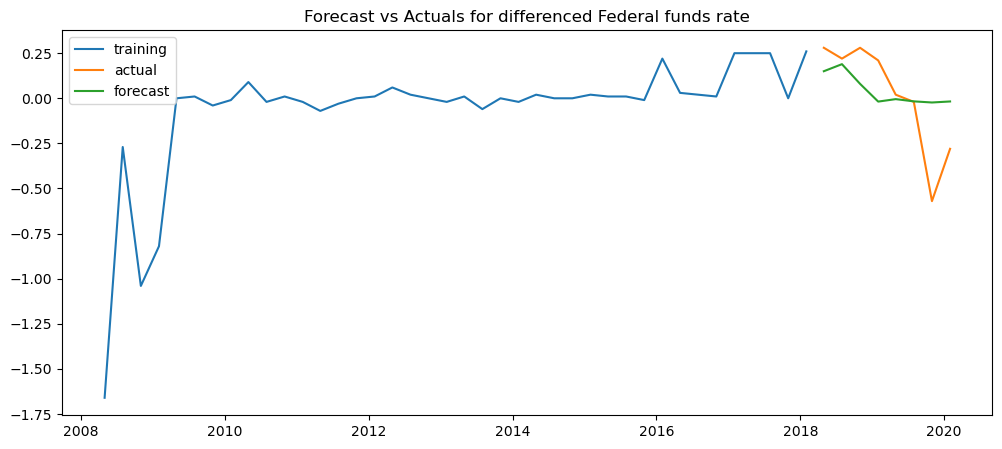

In [276]:

# 'figsize=(12,5)' sets the figure size to 12 inches wide and 5 inches tall for better readability
# 'dpi=100' sets the resolution to 100 dots per inch, ensuring a clear display
plt.figure(figsize=(12,5), dpi=100)

# Plot the last 40 quarters of the training data for the differenced federal funds rate ('dfedrate')
# 'train.dfedrate[-40:]' selects the last 40 quarters (10 years) from the training set to provide historical context
# 'label="training"' adds a label for the legend, and the line will be plotted in blue by default
plt.plot(train.dfedrate[-40:], label='training')

# Plot the actual differenced federal funds rate values from the test set
# 'test.dfedrate' contains the actual 'dfedrate' values for the last 8 quarters (test period, 2018–2019)
# 'label="actual"' adds a label for the legend, and the line will be plotted in green by default
plt.plot(test.dfedrate, label='actual')

# Plot the forecasted differenced federal funds rate values for the test period
# 'df_fc.dfedrate' contains the forecasted 'dfedrate' values for the same 8 quarters, generated by the VAR model
# 'label="forecast"' adds a label for the legend, and the line will be plotted in red by default
plt.plot(df_fc.dfedrate, label='forecast')

# Set the title of the plot to describe its content
plt.title('Forecast vs Actuals for differenced Federal funds rate')

# Add a legend to the plot to identify each line
# 'loc="upper left"' positions the legend in the upper-left corner for clarity with fontsize=10 for the legend
plt.legend(loc='upper left', fontsize=10)

#### Inflation Rate (inflat)
The aActual inflation fluctuates between 0% and 8%, but the forecast consistently overpredicts, staying above 4% and missing downward trends. The forecast significantly overpredicts inflation, failing to capture its decline, which matches the high MAE (4.44), RMSE (5.65), and overprediction bias (ME -2.73). The model misses key inflation dynamics.

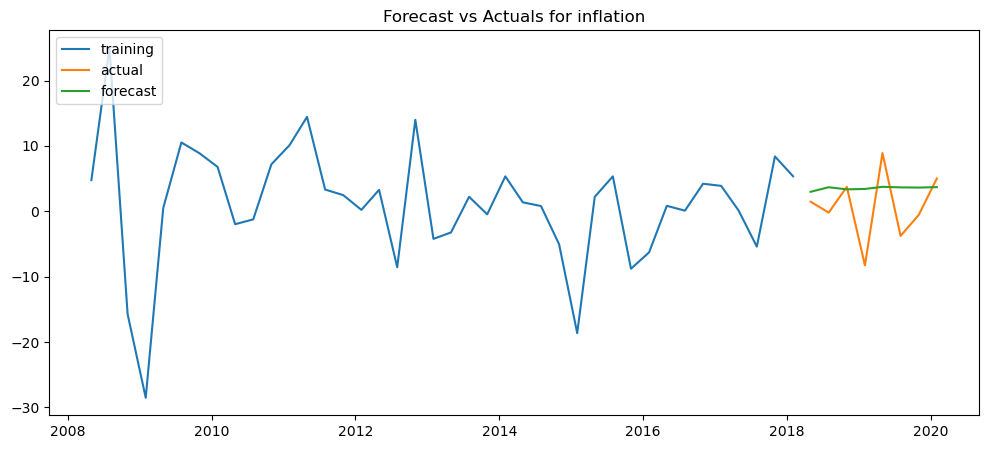

In [277]:
# Look at how well we did for the forecast visualy using the inflation avriable

#define the figure size
plt.figure(figsize=(12,5), dpi=100)

# We begi by plotting the train for the last decade (4 quarters per year x 10) for historical context 
plt.plot(train.inflat[-40:], label='training')

# Visualize the iflation variable for the test dataset ~ the recent 8 quarters
plt.plot(test.inflat, label='actual')

# Visualize the forecasted values for the inflation rate 
plt.plot(df_fc.inflat, label='forecast')

plt.title('Forecast vs Actuals for inflation')
plt.legend(loc='upper left', fontsize=10)

#### Unemployment Growth Rate (unempgr) prediction evaluation
The actual values fluctuate significantly (e.g., peaks above 5% and dips below -5%), while the forecast remains relatively flat, hovering around 0% to 1%. The forecast fails to capture the volatility in unemployment growth, underpredicting large swings. This aligns with the mean absolute value below, MAE (2.51) and RMSE (2.81), indicating moderate errors, and the slight underprediction bias (ME 0.69). The model struggles with abrupt changes, likely due to unmodeled economic shocks.

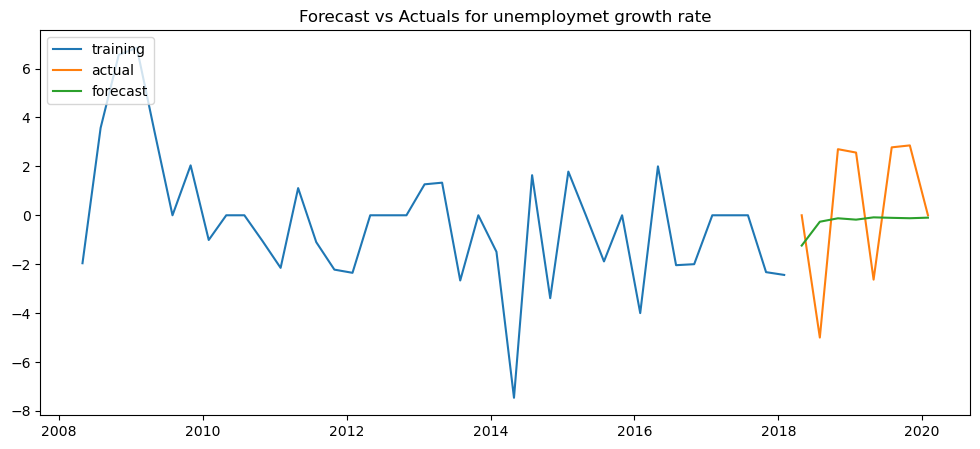

In [278]:
# Look at how well we did for the forecast visualy using the unemplyment growth rate
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.unempgr[-40:], label='training')
plt.plot(test.unempgr, label='actual')
plt.plot(df_fc.unempgr, label='forecast')
plt.title('Forecast vs Actuals for unemploymet growth rate')
plt.legend(loc='upper left', fontsize=10)

#### Invert the transformation (differencing) to get the real forecast

In [279]:
# Add the original federal funds rate ('fedrate') to the training set
# 'df.fedrate[1:-4]' selects 'fedrate' from the original DataFrame 'df', excluding the first row (due to differencing)
# and the last 4 rows (which will be part of the test set), aligning with the training set's time range

train['fedrate'] = df.fedrate[1:-4]

# Add the original federal funds rate ('fedrate') to the test set
# 'df.fedrate[-4:]' selects the last 4 rows of 'fedrate' from 'df', corresponding to the test period
# This ensures 'test' includes the actual federal funds rate for the last 4 quarters (e.g., 2018–2019)
test['fedrate'] = df.fedrate[-4:]

# Convert the forecasted differenced federal funds rate ('dfedrate') back to the actual federal funds rate ('fedrate')
# 'train.fedrate.iloc[-1]' gets the last known 'fedrate' value from the training set as the starting point
# 'df_fc.dfedrate.cumsum()' computes the cumulative sum of the forecasted 'dfedrate' values, representing the cumulative change
# Adding the last known 'fedrate' to this cumulative sum reconstructs the forecasted 'fedrate' over the test period
# This makes the forecast directly interpretable as the actual federal funds rate (e.g., 2.5% annualized rate)
df_fc['fedrate'] = train.fedrate.iloc[-1] + df_fc.dfedrate.cumsum()

# Display the forecast DataFrame for verification
# 'df_fc' now includes the forecasted 'fedrate' alongside 'unempgr', 'dfedrate', and 'inflat'
# This allows for direct comparison with the actual 'fedrate' in 'test' for evaluation (e.g., in a forecast vs. actuals plot)
df_fc

/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/549840862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fedrate'] = df.fedrate[1:-4]
/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/549840862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['fedrate'] = df.fedrate[-4:]


,unempgr,dfedrate,inflat,fedrate
DATE,,,,
2018-04-30,-1.238398,0.150066,2.976762,1.560066
2018-07-31,-0.263900,0.189162,3.675037,1.749227
2018-10-31,-0.123253,0.080081,3.350458,1.829308
2019-01-31,-0.178547,-0.018263,3.413170,1.811046
2019-04-30,-0.084696,-0.004645,3.738600,1.806400
2019-07-31,-0.104897,-0.017010,3.652417,1.789390
2019-10-31,-0.120786,-0.023266,3.622257,1.766124
2020-01-31,-0.097055,-0.017587,3.687681,1.748537


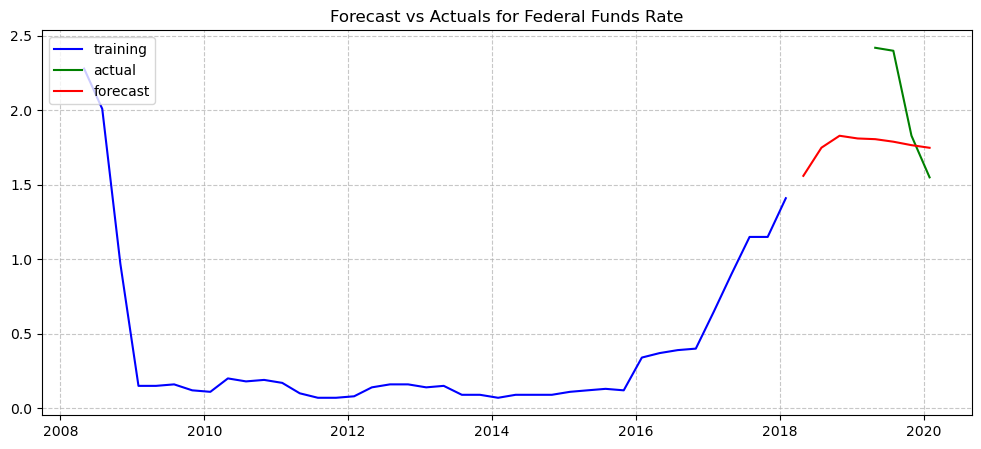

In [280]:
# Visualize Forecast vs Actuals for Federal Funds Rate
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.fedrate[-40:], label='training', color='blue')
plt.plot(test.fedrate, label='actual', color='green')
plt.plot(df_fc.fedrate, label='forecast', color='red')
plt.title('Forecast vs Actuals for Federal Funds Rate')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)


#### Model evaluation
The output shows the evaluation metrics (**ME**, **MAE**, **MPE**, **MAPE**, **RMSE**) for the Vector Autoregression (VAR) model’s predictions. 

#### Metrics Interpretation
- **ME (Mean Error)**: Average error (actual - forecast). Positive means underprediction; negative means overprediction.
- **MAE (Mean Absolute Error)**: Average absolute error, showing overall prediction error magnitude.
- **MPE (Mean Percentage Error)**: Average percentage error, indicating relative bias.
- **MAPE (Mean Absolute Percentage Error)**: Average absolute percentage error, showing relative error magnitude.
- **RMSE (Root Mean Squared Error)**: Square root of average squared errors, penalizing larger errors more.

#### Analysis of Results
#### unempgr (Unemployment Growth Rate)
- **ME: 0.6852**: Model underpredicts by 0.6852 on average, suggesting a slight positive bias.
- **MAE: 2.5060**: Average absolute error is 2.5060, indicating moderate prediction errors.
- **MPE/MAPE: inf%**: Infinite values occur because some actual `unempgr` values are zero or near-zero, causing division-by-zero in percentage calculations. This makes MPE/MAPE unusable here.
- **RMSE: 2.8095**: Slightly higher than MAE, suggesting some larger errors contribute to the overall fit.

#### dfedrate (Differenced Federal Funds Rate)
- **ME: -0.0248**: Slight overprediction by 0.0248 on average, nearly unbiased.
- **MAE: 0.1782**: Low absolute error, indicating good prediction accuracy.
- **MPE/MAPE: 71.0413%**: High relative error, likely due to small actual values (e.g., near-zero `dfedrate`), inflating percentage errors.
- **RMSE: 0.2445**: Low, showing consistent predictions with no major outliers.

#### inflat (Inflation Rate)
- **ME: -2.7288**: Significant overprediction by 2.7288 on average, indicating a strong negative bias.
- **MAE: 4.4442**: Large absolute error, reflecting poor prediction accuracy.
- **MPE: 371.8330%, MAPE: 397.6766%**: Extremely high relative errors, possibly due to small actual inflation values or large prediction errors, making percentage metrics less reliable.
- **RMSE: 5.6475**: High, indicating large errors, likely driven by outliers or systematic bias.

#### Model Performance Insights
- **unempgr**: Moderate errors (MAE: 2.5060, RMSE: 2.8095), but infinite MPE/MAPE due to zero/near-zero actual values. The model struggles slightly, with a small underprediction bias.
- **dfedrate**: Best performance (MAE: 0.1782, RMSE: 0.2445), with low errors and near-zero bias. High MAPE (71.0413%) is likely due to small actual values, not poor fit.
- **inflat**: Poor performance (MAE: 4.4442, RMSE: 5.6475), with significant overprediction (ME: -2.7288) and high relative errors. The model fails to capture inflation dynamics effectively.

### Most Appropriate Metric
- **MAE** and **RMSE** are most reliable here:
  - MAPE/MPE are distorted by small actual values (e.g., `unempgr` zeros, small `dfedrate`/`inflat`), making them less useful.
  - MAE provides a clear, scale-dependent error magnitude (e.g., 0.1782 for `dfedrate` is low, 4.4442 for `inflat` is high).
  - RMSE highlights larger errors (e.g., 5.6475 for `inflat`), critical for economic forecasts where big deviations matter (e.g., during a recession).
- **dfedrate** predictions are accurate, while `inflat` predictions need improvement (e.g., more lags, additional predictors like GDP).

In [285]:
import numpy as np

# Extract actual values from the test set (last 8 quarters)
actual = test[['unempgr', 'dfedrate', 'inflat']].values  # Shape: (8, 3)

# Forecasted values from the VAR model (already computed as 'fc')
forecast = fc  # Shape: (8, 3)

# Compute errors (actual - forecast) for each variable
errors = actual - forecast

# Mean Error (ME)
ME = np.mean(errors, axis=0)  # Average error per variable

# Mean Absolute Error (MAE)
MAE = np.mean(np.abs(errors), axis=0)  # Average absolute error per variable

# Mean Percentage Error (MPE)
MPE = np.mean(errors / actual * 100, axis=0)  # Average percentage error per variable

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean(np.abs(errors / actual) * 100, axis=0)  # Average absolute percentage error per variable

# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(np.mean(errors**2, axis=0))  # Square root of average squared error per variable

# Print results for each variable
variables = ['unempgr', 'dfedrate', 'inflat']
for i, var in enumerate(variables):
    print(f"\nMetrics for {var}:")
    print(f"ME: {ME[i]:.4f}")
    print(f"MAE: {MAE[i]:.4f}")
    print(f"MPE: {MPE[i]:.4f}%")
    print(f"MAPE: {MAPE[i]:.4f}%")
    print(f"RMSE: {RMSE[i]:.4f}")


Metrics for unempgr:
ME: 0.6852
MAE: 2.5060
MPE: inf%
MAPE: inf%
RMSE: 2.8095

Metrics for dfedrate:
ME: -0.0248
MAE: 0.1782
MPE: 71.0413%
MAPE: 71.0413%
RMSE: 0.2445

Metrics for inflat:
ME: -2.7288
MAE: 4.4442
MPE: 371.8330%
MAPE: 397.6766%
RMSE: 5.6475


/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/311501295.py:19: RuntimeWarning: divide by zero encountered in divide
  MPE = np.mean(errors / actual * 100, axis=0)  # Average percentage error per variable
/var/folders/gl/sc9s01490bg0vmyvzpbkn1lm0000gn/T/ipykernel_85973/311501295.py:22: RuntimeWarning: divide by zero encountered in divide
  MAPE = np.mean(np.abs(errors / actual) * 100, axis=0)  # Average absolute percentage error per variable


### 6] Granger Causality

**The primary goal is to evaluate the effect of monetary policy (via the federal funds rate) on inflation and unemployment.** This involves:

Understanding how changes in the federal funds rate (dfedrate) influence unemployment growth (unempgr) and inflation (inflat).

Here is why we use Granger Causality. It is about predictive power, not true causation. It checks if past variables of one time series (X) improve the predictions of another time series (Y) but does not necessarily mean X causes Y.

If dfedrate Granger-causes unempgr, it means past dfedrate values improve predictions of unempgr, but this doesn’t necessarily mean dfedrate causes unempgr in a physical or economic sense. It gives a sense of direction to the relationship revealed by the Vector autoregression model. A prerequisite for Granger causality is stationarity of the variables.

In [191]:
from statsmodels.tsa.stattools import grangercausalitytests

#### 6a] Test if the differenced federal funds rate Granger-causes unemployment growth rate

In [255]:
# create a dataframe for the two variables of concern and run Granger causality with 3 lags
df_gc=pd.DataFrame({'dfedrate': df.dfedrate[1:], 'unempgr': df.unempgr[1:]})
df_gc.head()

,dfedrate,unempgr
DATE,,
1970-04-30,-0.88,4.545455
1970-07-31,-0.89,2.040816
1970-10-31,-1.01,1.851852
1971-01-31,-2.06,-3.278689
1971-04-30,0.02,-1.666667


In [256]:
gc_results=grangercausalitytests(df_gc,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3009 , p=0.0002  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=14.5198 , p=0.0001  , df=1
likelihood ratio test: chi2=14.0145 , p=0.0002  , df=1
parameter F test:         F=14.3009 , p=0.0002  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3630  , p=0.0008  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=15.1076 , p=0.0005  , df=2
likelihood ratio test: chi2=14.5589 , p=0.0007  , df=2
parameter F test:         F=7.3630  , p=0.0008  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7296  , p=0.0033  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=14.7115 , p=0.0021  , df=3
likelihood ratio test: chi2=14.1881 , p=0.0027  , df=3
parameter F test:         F=4.7296  , p=0.0033  , df_denom=190, df_num=3


#### 6b] Test if the differenced federal funds rate Granger-causes inflation

In [257]:
# create a dataframe for the two variables of concern and run Granger causality with 3 lags
df_gc2=pd.DataFrame({'dfedrate': df.dfedrate[1:],'inflat': df.inflat[1:]})
df_gc2.head()

,dfedrate,inflat
DATE,,
1970-04-30,-0.88,2.988400
1970-07-31,-0.89,2.820601
1970-10-31,-1.01,4.140483
1971-01-31,-2.06,2.385616
1971-04-30,0.02,3.513699


In [258]:
gc_results=grangercausalitytests(df_gc2,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3744  , p=0.2425  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=1.3954  , p=0.2375  , df=1
likelihood ratio test: chi2=1.3905  , p=0.2383  , df=1
parameter F test:         F=1.3744  , p=0.2425  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9520  , p=0.3878  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=1.9533  , p=0.3766  , df=2
likelihood ratio test: chi2=1.9438  , p=0.3784  , df=2
parameter F test:         F=0.9520  , p=0.3878  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4160  , p=0.7417  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=1.2940  , p=0.7306  , df=3
likelihood ratio test: chi2=1.2898  , p=0.7316  , df=3
parameter F test:         F=0.4160  , p=0.7417  , df_denom=190, df_num=3


#### 6c] Test if the unemployment growth rate Granger-causes inflation

In [259]:
df_gc3=pd.DataFrame({ 'unempgr': df.unempgr[1:],  'inflat': df.inflat[1:]})
df_gc3.head()

,unempgr,inflat
DATE,,
1970-04-30,4.545455,2.988400
1970-07-31,2.040816,2.820601
1970-10-31,1.851852,4.140483
1971-01-31,-3.278689,2.385616
1971-04-30,-1.666667,3.513699


In [260]:
gc_results=grangercausalitytests(df_gc3,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2044  , p=0.2738  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=1.2228  , p=0.2688  , df=1
likelihood ratio test: chi2=1.2191  , p=0.2695  , df=1
parameter F test:         F=1.2044  , p=0.2738  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0415  , p=0.3549  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=2.1369  , p=0.3435  , df=2
likelihood ratio test: chi2=2.1255  , p=0.3455  , df=2
parameter F test:         F=1.0415  , p=0.3549  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1731  , p=0.0926  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=6.7593  , p=0.0800  , df=3
likelihood ratio test: chi2=6.6460  , p=0.0841  , df=3
parameter F test:         F=2.1731  , p=0.0926  , df_denom=190, df_num=3


### The Granger-causality results show that:

1) 'dfedrate' Granger-causes 'unempgr' (the p-value < 0.001 for the 3 previous quarters), meaning past changes in the differenced federal funds rate are useful for predicting unemployment growth rate. This supports the idea that monetary policy impacts unemployment. These p-values are precisely p = 0.0002 for lag 1, p = 0.0008 for lag 2, p = 0.0033 for lag 3 respectively.

2) The differenced federal funds rate does not Granger-cause inflation as seen by the p-values (p = 0.2425 for lag 1, p = 0.3878 for lag 2 ad p=0.7417 for lag 3) for all three lags. 

3) The unemployment growth rate does not Granger-cause inflation as seen by the p-values (p = 0.2738 for lag 1, p = 0.3549 for lag 2 and p=0.0926 for lag 3) for all three lags. 

### Conclusion 
The VAR model captured bidirectional relationships (e.g., differenced fedrate lending rates affects unemployment growth rate, and unemployment growth rate affects differenced fedrate lending rates), but it doesn’t explicitly test which direction is statistically significant. Granger Causality tests provide this directional insight showing that differenced fedrate lending rates Granger-causes unemployment growth rate, meaning `past changes in the federal funds rate are useful for predicting unemployment growth`. This supports the idea that monetary policy impacts unemployment. Thus, to address high levels of unemployment, the Federal Reserve should consider lowering interest rates or increasing the money supply to stimulate spending and encourage hiring.

The lack of Granger Causality from differenced fedrate lending rates to inflation challenges the recommendation to raise rates to combat inflation, as the model suggests limited predictive power in this direction. This finding aligns with the VAR results, where differenced federal lending rate unexpectedly increased inflation, prompting the need for a structural VAR (SVAR) to capture contemporaneous effects. The next phase of this project will address this question. 